In [1]:
import gym

import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
import json
from tqdm import tqdm
import math
import random
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.integrate as integrate
from scipy.stats import multivariate_normal
from sklearn import linear_model
#from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
#import statsmodels.api as sm
from matplotlib.colors import LogNorm
import pickle

from joblib import Parallel, delayed
import multiprocessing
from collections import namedtuple
from itertools import count

import cProfile
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

#sns.set_style("whitegrid")
#sns.set_palette("colorblind")
#palette = sns.color_palette()
#figsize = (15,8)
#legend_fontsize = 16

#from matplotlib import rc
#rc('font',**{'family':'sans-serif'})
#rc('text', usetex=True)
#rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
#rc('text.latex',preamble=r'\usepackage[russian]{babel}')
#rc('figure', **{'dpi': 300})

## TicTacToe

In [2]:
N_ROWS, N_COLS, N_WIN = 3, 3, 3

In [3]:
class TicTacToe(gym.Env):
    def __init__(self, n_rows=N_ROWS, n_cols=N_COLS, n_win=N_WIN, clone=None):
        if clone is not None:
            self.n_rows, self.n_cols, self.n_win = clone.n_rows, clone.n_cols, clone.n_win
            self.board = copy.deepcopy(clone.board)
            self.curTurn = clone.curTurn
            self.emptySpaces = None
            self.boardHash = None
        else:
            self.n_rows = n_rows
            self.n_cols = n_cols
            self.n_win = n_win

            self.reset()

    def getEmptySpaces(self):
        if self.emptySpaces is None:
            res = np.where(self.board == 0)
            self.emptySpaces = np.array([ (i, j) for i,j in zip(res[0], res[1]) ])
        return self.emptySpaces

    def makeMove(self, player, i, j):
        self.board[i, j] = player
        self.emptySpaces = None
        self.boardHash = None

    def getHash(self):
        if self.boardHash is None:
            self.boardHash = ''.join(['%s' % (x+1) for x in self.board.reshape(self.n_rows * self.n_cols)])
        return self.boardHash

    def isTerminal(self):
        #
        cur_marks, cur_p = np.where(self.board == self.curTurn), self.curTurn
        for i,j in zip(cur_marks[0], cur_marks[1]):
            win = False
            if i <= self.n_rows - self.n_win:
                if np.all(self.board[i:i+self.n_win, j] == cur_p):
                    win = True
            if not win:
                if j <= self.n_cols - self.n_win:
                    if np.all(self.board[i,j:j+self.n_win] == cur_p):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j <= self.n_cols - self.n_win:
                    if np.all(np.array([ self.board[i+k,j+k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if not win:
                if i <= self.n_rows - self.n_win and j >= self.n_win-1:
                    if np.all(np.array([ self.board[i+k,j-k] == cur_p for k in range(self.n_win) ])):
                        win = True
            if win:
                self.gameOver = True
                return self.curTurn

        if len(self.getEmptySpaces()) == 0:
            self.gameOver = True
            return 0

        self.gameOver = False
        return None

    def printBoard(self):
        for i in range(0, self.n_rows):
            print('----'*(self.n_cols)+'-')
            out = '| '
            for j in range(0, self.n_cols):
                if self.board[i, j] == 1:
                    token = 'x'
                if self.board[i, j] == -1:
                    token = 'o'
                if self.board[i, j] == 0:
                    token = ' '
                out += token + ' | '
            print(out)
        print('----'*(self.n_cols)+'-')

    def getState(self):
        return (self.getHash(), self.getEmptySpaces(), self.curTurn)

    def action_from_int(self, action_int):
        return ( int(action_int / self.n_cols), int(action_int % self.n_cols))

    def int_from_action(self, action):
        return action[0] * self.n_cols + action[1]
    
    def step(self, action):
        if self.board[action[0], action[1]] != 0:
            return self.getState(), -10, True, {}
        self.makeMove(self.curTurn, action[0], action[1])
        reward = self.isTerminal()
        self.curTurn = -self.curTurn
        return self.getState(), 0 if reward is None else reward, reward is not None, {}

    def reset(self):
        self.board = np.zeros((self.n_rows, self.n_cols), dtype=int)
        self.boardHash = None
        self.gameOver = False
        self.emptySpaces = None
        self.curTurn = 1

In [4]:
class pi():
    def __init__(self, ):
        self.Q = {}
        self.hist = []
    def getActionGreedy(self, s, num_a, actions):
        max_v = -np.inf
        acts = set()
        for i in range(num_a):
            if ( not s in self.Q.keys()) or (not env.int_from_action(actions[i]) in self.Q[s].keys()):
                v = 0
            else:
                v = self.Q[s][env.int_from_action(actions[i])]
            if max_v < v:
                max_v = v
                acts = set([i])
            elif max_v == v:
                acts.add(i)
            
        acts = list(acts)
        if len(acts) > 1:
            a_idx = np.random.randint(0, len(acts) - 1)
        else:
            a_idx = 0
            
        self.hist.append((s, env.int_from_action(actions[acts[a_idx]])))
        return acts[a_idx]
        
    def update(self, rew, alpha=0.5, gamma=0.9):
        #for s in self.Q.keys():
        for i in range(len(self.hist) - 1, 0, -1):
            s, a = self.hist[i]
            if not s in self.Q.keys():
                self.Q[s] = {}
            if not a in self.Q[s].keys():
                self.Q[s][a] = 0
        
            self.Q[s][a] += alpha * (gamma * rew - self.Q[s][a])
            rew = self.Q[s][a]
    def reset(self):
        self.hist = []

In [5]:
def plot_board(env, pi, showtext=True, verbose=True, fontq=20, fontx=60):
    "Рисуем доску с оценками из стратегии pi"
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    X, Y = np.meshgrid(np.arange(0, env.n_rows), np.arange(0, env.n_rows))
    Z = np.zeros((env.n_rows, env.n_cols)) + .01
    s, actions = env.getHash(), env.getEmptySpaces()
    if pi is not None and s in pi.Q:
        for i, a in enumerate(actions):
            Z[a[0], a[1]] = pi.Q[s][i]
    ax.set_xticks([])
    ax.set_yticks([])
    surf = ax.imshow(Z, cmap=plt.get_cmap('Accent', 10), vmin=-1, vmax=1)
    if showtext:
        for i,a in enumerate(actions):
            if pi is not None and s in pi.Q:
                ax.text( a[1] , a[0] , "%.3f" % pi.Q[s][i], fontsize=fontq, horizontalalignment='center', verticalalignment='center', color="w" )
    for i in range(env.n_rows):
        for j in range(env.n_cols):
            if env.board[i, j] == -1:
                ax.text(j, i, "O", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
            if env.board[i, j] == 1:
                ax.text(j, i, "X", fontsize=fontx, horizontalalignment='center', verticalalignment='center', color="w" )
#     cbar = plt.colorbar(surf, ticks=[0, 1])
    ax.grid(False)
    plt.show()

def get_and_print_move(env, pi, s, actions, plot=False, random=False, verbose=True, fontq=20, fontx=60):
    if plot!=False:
        "Делаем ход, рисуем доску"
        plot_board(env, pi, fontq=fontq, fontx=fontx)
    if verbose and (pi is not None):
        if s in pi.Q:
            for i,a in enumerate(actions):
                if not i in pi.Q[s]:
                    v = 0
                else:
                    v = pi.Q[s][i]
                print(i, a, v)
        else:
            print("Стратегия не знает, что делать")
    if random:
        return np.random.randint(len(actions))
    else:
        return pi.getActionGreedy(s, len(actions), actions)

In [6]:
def plot_test_game(env, pi1, pi2, random_crosses=False, random_naughts=True, plot=False, verbose=True, fontq=20, fontx=60):
    "Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры"
    done = False
    env.reset()
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            if plot!=False:
                print("Крестики выиграли!")
                plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
        if reward == -1:
            if plot!=False:
                print("Нолики выиграли!")
                plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
    return reward

In [7]:
def plot_Q_game(env, pi1, pi2, random_crosses=False, random_naughts=True, plot=False, verbose=True, fontq=20, fontx=60):
    "Играем тестовую партию между стратегиями или со случайными ходами, рисуем ход игры"
    done = False
    env.reset()
    if pi1 != None:
        pi1.reset()
    if pi2 != None:
        pi2.reset()
    
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        if env.curTurn == 1:
            a = get_and_print_move(env, pi1, s, actions, random=random_crosses, verbose=verbose, fontq=fontq, fontx=fontx)
        else:
            a = get_and_print_move(env, pi2, s, actions, random=random_naughts, verbose=verbose, fontq=fontq, fontx=fontx)
        observation, reward, done, info = env.step(actions[a])
        if reward == 1:
            if pi1 != None:
                pi1.update(1)
            if pi2 != None:
                pi2.update(-1)
            if plot!=False:
                print("Крестики выиграли!")
                plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
            
        if reward == -1:
            if pi1 != None:
                pi1.update(-1)
            if pi2 != None:
                pi2.update(1)
            if plot!=False:
                print("Нолики выиграли!")
                plot_board(env, None, showtext=False, fontq=fontq, fontx=fontx)
    return reward

In [8]:
def moving_average(a, n=100):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# 3x3

In [16]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n_epochs = 10000
reward_rand = []
for epoch in tqdm(range(n_epochs)):
    reward_rand.append(plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60))

100%|███████████████████████████████████| 10000/10000 [00:07<00:00, 1375.65it/s]


In [17]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n_epochs = 10000
reward_pi_xy= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_xy.append(plot_Q_game(env, pi1, pi2, random_crosses=False, random_naughts=False, verbose=False, fontx=60))

100%|███████████████████████████████████| 10000/10000 [00:09<00:00, 1055.33it/s]


In [18]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n_epochs = 10000
reward_pi_x= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_x.append(plot_Q_game(env, pi1, None, random_crosses=False, random_naughts=True, verbose=False, fontx=60))

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1617.86it/s]


In [19]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)
n_epochs = 10000
reward_pi_y= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_y.append(plot_Q_game(env, None, pi2, random_crosses=True, random_naughts=False, verbose=False, fontx=60))

100%|███████████████████████████████████| 10000/10000 [00:06<00:00, 1499.31it/s]


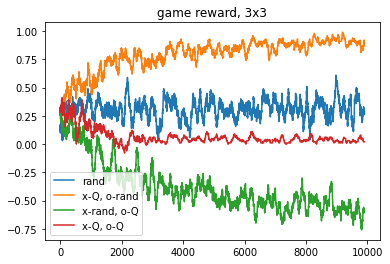

In [20]:
plt.title('game reward, 3x3')
plt.plot(moving_average(reward_rand), label='rand')
plt.plot(moving_average(reward_pi_x), label='x-Q, o-rand')
plt.plot(moving_average(reward_pi_y), label='x-rand, o-Q')
plt.plot(moving_average(reward_pi_xy), label='x-Q, o-Q')
plt.legend()

# 4x4

In [12]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
n_epochs = 100000
reward_rand = []
for epoch in tqdm(range(n_epochs)):
    reward_rand.append(plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60))

100%|██████████████████████████████████| 100000/100000 [02:42<00:00, 614.07it/s]


In [9]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
n_epochs = 100000
reward_pi_xy= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_xy.append(plot_Q_game(env, pi1, pi2, random_crosses=False, random_naughts=False, verbose=False, fontx=60))

100%|██████████████████████████████████| 100000/100000 [03:09<00:00, 528.31it/s]


In [13]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
n_epochs = 100000
reward_pi_x= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_x.append(plot_Q_game(env, pi1, None, random_crosses=False, random_naughts=True, verbose=False, fontx=60))

100%|██████████████████████████████████| 100000/100000 [03:05<00:00, 539.94it/s]


In [14]:
pi1 = pi()
pi2 = pi()
env = TicTacToe(n_rows=4, n_cols=4, n_win=4)
n_epochs = 100000
reward_pi_y= []
for epoch in tqdm(range(n_epochs)):
    reward_pi_y.append(plot_Q_game(env, None, pi2, random_crosses=True, random_naughts=False, verbose=False, fontx=60))

100%|██████████████████████████████████| 100000/100000 [02:55<00:00, 568.20it/s]


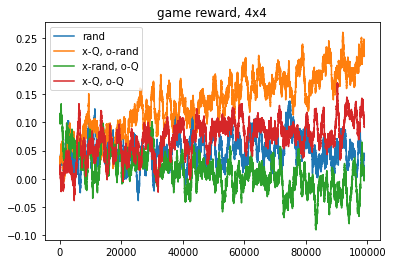

In [15]:
plt.title('game reward, 4x4')
plt.plot(moving_average(reward_rand, 1000), label='rand')
plt.plot(moving_average(reward_pi_x, 1000), label='x-Q, o-rand')
plt.plot(moving_average(reward_pi_y, 1000), label='x-rand, o-Q')
plt.plot(moving_average(reward_pi_xy, 1000), label='x-Q, o-Q')
plt.legend()